In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
%matplotlib inline

In [3]:
df_train = pd.read_csv("../data/train_new.csv")
print('Number of train records: {}'.format(len(df_train)))
df_train.head()

Number of train records: 60000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.038835,0,0,0,0,1,2461.419769,2334.161163,2,67.0,...,1,0,0,0,0,0,0,0,0,1
1,0.504854,0,0,0,1,0,2371.483467,2341.480947,2,92.0,...,0,1,0,0,0,0,1,0,0,0
2,0.529126,0,0,0,1,1,2465.059892,2429.073831,7,67.0,...,1,0,0,0,0,1,0,0,0,0
3,0.033981,0,0,1,0,0,2419.540115,2635.040637,9,149.0,...,0,0,1,0,0,0,1,0,0,0
4,0.533981,0,0,1,0,1,2479.255239,2173.943626,7,68.0,...,1,0,0,0,0,1,0,0,0,0


In [4]:
df_test = pd.read_csv("../data/test_new.csv")
print('Number of test records: {}'.format(len(df_test)))
df_test.head()

Number of test records: 30000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.970874,1,0,1,1,1,2624.520690,2379.499974,7,121.0,...,0,0,0,1,0,0,0,0,1,0
1,0.524272,0,1,1,1,0,2524.058532,2615.882473,6,100.0,...,0,1,0,0,0,0,0,1,0,0
2,1.000000,0,1,1,0,0,2696.577167,2567.505982,2,91.0,...,0,1,0,0,0,0,0,0,0,1
3,0.033981,0,0,0,0,1,2515.834726,2821.948226,6,74.0,...,1,0,0,0,0,0,0,0,0,1
4,0.495146,0,0,0,0,1,2609.989756,2282.274343,7,121.0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# print(df_train.columns)
cols = ['rent_approval_date', 
        'town_0', 'town_1', 'town_2', 'town_3', 'town_4', #for binary encoding
#         'town', #for target encoding 
       'flat_model', 'floor_area_sqm', 'lease_commence_date',
       'avg_stock_price', 'num_shopping_malls', 'min_distance',
       'avg_coe_price', 'num_primary_schools', 'min_distance_planned',
       'flat_type_3-room', 'flat_type_4-room', 'flat_type_executive', 'flat_type_5-room', 'flat_type_2-room',
       'central region', 'east region', 'north region', 'north-east region', 'west region',
       'subzone', 'latitude', 'longitude'] #removed: 'furnished', 'elevation', 'planning_area', 'street_name', 'block'
"""
TODO:
1. submit output with subzone + lat/lon, SK learning rate 0.13, l2 2.9 
    -- SK 481.33169, XG???, CAT 482.53131(although lower MAE, overfitting?), LGB 484.28856
2. submit output with town target encoding instead of binary. SK lr 0.15, l2 2.9 
    -- SK 481.96167 --> choose binary encoding
"""

y_train = df_train['monthly_rent'].values
X_train = df_train[cols].values

X_test = df_test[cols].values

# Gradient Boosting with SKLearn

### Use HistGradientBoostingRegressor since it's much faster for large dataset

In [6]:
%%time
categorical_features = []

model = HistGradientBoostingRegressor( loss='gamma',
                                        learning_rate=0.13, 
                                        max_depth=None,
                                        max_bins=255,
                                        categorical_features=categorical_features,
                                        random_state=237,
                                        l2_regularization=2.9) 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
 
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

MAE: -365.926 (4.729)
CPU times: user 111 ms, sys: 115 ms, total: 226 ms
Wall time: 4.44 s


# Gradient Boosting with XGBoost

MAE: -365.482 (4.929)
30000
[3291, 2726, 3587, 1958, 2655]


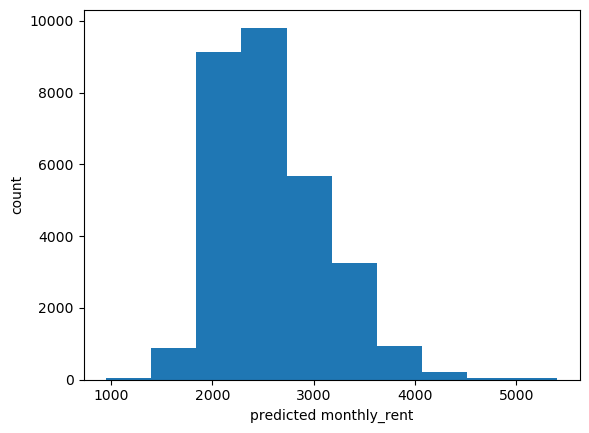

CPU times: user 3.52 s, sys: 225 ms, total: 3.74 s
Wall time: 45.2 s


In [7]:
%%time


model = XGBRegressor(objective ='reg:squarederror', alpha = 14, eta=0.11, max_depth=6, subsample=0.93)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

In [8]:
"""subsample tuning:
i:  0.6
MAE: -366.184 (4.850)
i:  0.61
MAE: -365.952 (4.900)
i:  0.62
MAE: -366.019 (5.074)
i:  0.63
MAE: -365.904 (5.079)
i:  0.64
MAE: -365.881 (5.008)
i:  0.65
MAE: -366.047 (5.035)
i:  0.66
MAE: -365.960 (5.150)
i:  0.67
MAE: -365.843 (5.097)
i:  0.68
MAE: -365.788 (5.056)
i:  0.6900000000000001
MAE: -365.877 (4.875)
i:  0.7000000000000001
MAE: -365.787 (4.867)
i:  0.7100000000000001
MAE: -365.842 (4.800)
i:  0.7200000000000001
MAE: -365.703 (4.943)
i:  0.7300000000000001
MAE: -365.712 (4.915)
i:  0.7400000000000001
MAE: -365.535 (4.950)
i:  0.7500000000000001
MAE: -365.697 (4.949)
i:  0.7600000000000001
MAE: -365.748 (4.951)
i:  0.7700000000000001
MAE: -365.623 (4.866)
i:  0.7800000000000001
MAE: -365.777 (4.920)
i:  0.7900000000000001
MAE: -365.651 (5.203)
i:  0.8000000000000002
MAE: -365.669 (4.959)
i:  0.8100000000000002
MAE: -365.723 (4.878)
i:  0.8200000000000002
MAE: -365.594 (4.901)
i:  0.8300000000000002
MAE: -365.670 (5.018)
i:  0.8400000000000002
MAE: -365.855 (5.034)
i:  0.8500000000000002
MAE: -365.714 (5.019)
i:  0.8600000000000002
MAE: -365.789 (4.887)
i:  0.8700000000000002
MAE: -365.681 (4.834)
i:  0.8800000000000002
MAE: -365.732 (4.893)
i:  0.8900000000000002
MAE: -365.673 (4.926)
i:  0.9000000000000002
MAE: -365.552 (4.836)
i:  0.9100000000000003
MAE: -365.764 (4.857)
i:  0.9200000000000003
MAE: -365.615 (4.769)
i:  0.9300000000000003
MAE: -365.482 (4.929)
i:  0.9400000000000003
MAE: -365.727 (4.893)
i:  0.9500000000000003
MAE: -365.609 (4.840)
i:  0.9600000000000003
MAE: -365.605 (4.889)
i:  0.9700000000000003
MAE: -365.688 (4.963)
i:  0.9800000000000003
MAE: -365.686 (4.814)
i:  0.9900000000000003
MAE: -365.659 (4.805)
i:  1.0000000000000004
MAE: -365.613 (4.763)
"""

'subsample tuning:\ni:  0.6\nMAE: -366.184 (4.850)\ni:  0.61\nMAE: -365.952 (4.900)\ni:  0.62\nMAE: -366.019 (5.074)\ni:  0.63\nMAE: -365.904 (5.079)\ni:  0.64\nMAE: -365.881 (5.008)\ni:  0.65\nMAE: -366.047 (5.035)\ni:  0.66\nMAE: -365.960 (5.150)\ni:  0.67\nMAE: -365.843 (5.097)\ni:  0.68\nMAE: -365.788 (5.056)\ni:  0.6900000000000001\nMAE: -365.877 (4.875)\ni:  0.7000000000000001\nMAE: -365.787 (4.867)\ni:  0.7100000000000001\nMAE: -365.842 (4.800)\ni:  0.7200000000000001\nMAE: -365.703 (4.943)\ni:  0.7300000000000001\nMAE: -365.712 (4.915)\ni:  0.7400000000000001\nMAE: -365.535 (4.950)\ni:  0.7500000000000001\nMAE: -365.697 (4.949)\ni:  0.7600000000000001\nMAE: -365.748 (4.951)\ni:  0.7700000000000001\nMAE: -365.623 (4.866)\ni:  0.7800000000000001\nMAE: -365.777 (4.920)\ni:  0.7900000000000001\nMAE: -365.651 (5.203)\ni:  0.8000000000000002\nMAE: -365.669 (4.959)\ni:  0.8100000000000002\nMAE: -365.723 (4.878)\ni:  0.8200000000000002\nMAE: -365.594 (4.901)\ni:  0.8300000000000002\nMA

# Gradient Boosting with CatBoost

In [9]:
%%time
model = CatBoostRegressor(verbose=0, n_estimators=255)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

MAE: -365.753 (4.837)
CPU times: user 44.1 ms, sys: 14.4 ms, total: 58.6 ms
Wall time: 38.2 s


# Gradient Boosting with LightGBM

In [10]:
%%time
params = {
    "objective": "regression",
    "metric": "mse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
}

train_data = lgb.Dataset(X_train, label=y_train)
num_round = 1000
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=num_round,
    nfold=10,
    stratified=False,
)

best_round = len(cv_results["valid l2-mean"])
model = lgb.train(params, train_data, num_boost_round=best_round)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data p

In [11]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.head()

,Predicted
0,3291.0
1,2726.0
2,3587.0
3,1958.0
4,2655.0


In [12]:
df.to_csv("../data/gb_output.csv", index_label='Id')